# Link between winter lead fraction (JFM) and cumulative ice volume flux (Jan 01-June 01) 

Look at the link between winter lead area fraction, the cool season cumulative ice volume flux and cool season ice volume in the Beaufort Sea 

In [2]:
%matplotlib inline
import sys,os
sys.path.append('../src')
import xarray as xr
import datetime as dt
import pandas as pd
import numpy as np
import cmocean
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec

from brkup_utils import process_data
from brkup_utils import mask_funcs as msk
from brkup_utils import lead_detect as lead_det
from brkup_utils.boxnames import *
from brkup_utils import grid_funcs as grd
from brkup_utils import plot_funcs
from brkup_utils import calc_IceGrowth as ig

In [3]:
# set environment
os.environ['INPUT_OBS_DATA_DIR'] = '/home/rheinlender/shared-simstore-ns9829k/data/'
os.environ['NEXTSIM_MESH_DIR'] = os.environ['INPUT_OBS_DATA_DIR'] + 'mesh/'

# set directories
INDIR = '/home/rheinlender/shared-simstore-ns9829k/NANUK/NANUK025-ILBOXE140-S/'    


months: ['01', '02', '03', '04', '05', '06']
years: [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
bbox for Beaufort : (95, 225, 425, 575)
DONE!


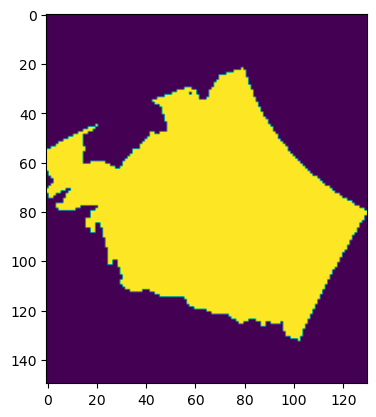

In [4]:
##############################
# get moorings
##############################

months = ['01', '02', '03', '04', '05', '06']
years = list(range(2000, 2019))
region = 'Beaufort'
ds =  process_data.load_moorings(INDIR,months,years,region=region ,period=None)

##############################
# calculate masks
##############################

bbox = BOXNAMES[region]
Mask = msk.Masking(ds, bbox=bbox)
msk_moore22 = Mask.get_Moore2022_Beaufort_mask()

plt.imshow(msk_moore22)

##############################
# Grid Info
##############################

# get area info from model grid and add to dataset
creg_grid = grd.CREGgrid('/home/rheinlender/projects/beaufort-breakup-nextsimOPA/grid_files', bbox)
ds['mod_area'] = (('y','x'), creg_grid.get_area())
ds['mod_area'].attrs = {'units':'m2', 'long_name':'grid_cell_area'}

# get land/ocean mask (1=ocn, 0=land) 
ds['tmask'] = ~ds.mod_area.isnull()  

## Ice volume fluxes 

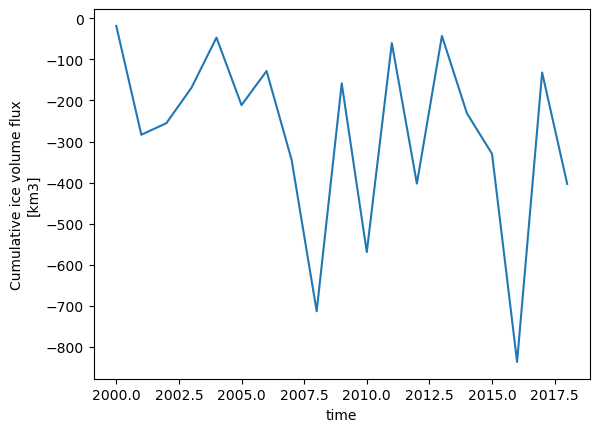

In [5]:
# Cumulative fluxes from Jan through May (cool season)
# these are the ice volume fluxes through the Beaufort region calculated by H. Regan (NERSC) 
ds3 = xr.open_dataset('../data_input/Exports_MooreBox_JFMAMJ_cumul.nc') 

iceFlux_cool = []
for yr,var in ds3.SIvolume_Net.groupby('time.year'):
    tmp = var.sel(time=var.time.dt.month.isin([1,2,3,4,5])) # cumulative fluxes 
    iceFlux_cool.append(tmp.cumsum(axis=0).values[-1]) # end of cool season (June 1)

    
times = ds3.time.groupby('time.year').mean()

volFlx_cool = xr.DataArray(
    data=iceFlux_cool,
    dims=["time"],
    coords=dict(
        time=times.year.values,
    ),
    attrs=dict(
        
        description="Cumulative Jan 1 - June 1 Ice Volume Flux Beaufort Sea",
        long_name="Cumulative ice volume flux", 
        units="km3",
    ),
)

volFlx_coolAnom = volFlx_cool - volFlx_cool.mean('time')
volFlx_cool.plot()


In [6]:
volFlx_cool.sel(time=2016)

<xarray.DataArray ()>
array(-836.3656786)
Coordinates:
    time     int64 2016
Attributes:
    description:  Cumulative Jan 1 - June 1 Ice Volume Flux Beaufort Sea
    long_name:    Cumulative ice volume flux
    units:        km3

In [13]:
## Calculate climatology of ice volume flux on June 1

volFlx_coolClim = volFlx_cool.mean('time').values

print('June 1 climatological ice volume flux (2000-2018)', volFlx_coolClim, 'km3')

for yr in years:
    print('June 1st ice volume transport in',yr,':', volFlx_cool.sel(time=yr).values, 'km3')

June 1 climatological ice volume flux (2000-2018) -280.9539951944749 km3
June 1st ice volume transport in 2000 : -18.675653207406228 km3
June 1st ice volume transport in 2001 : -283.54673961760545 km3
June 1st ice volume transport in 2002 : -255.32241172860938 km3
June 1st ice volume transport in 2003 : -169.39425835754298 km3
June 1st ice volume transport in 2004 : -46.96742577778906 km3
June 1st ice volume transport in 2005 : -211.39997613661328 km3
June 1st ice volume transport in 2006 : -128.41603709043753 km3
June 1st ice volume transport in 2007 : -344.67545551994533 km3
June 1st ice volume transport in 2008 : -713.0331385947031 km3
June 1st ice volume transport in 2009 : -158.6227898371914 km3
June 1st ice volume transport in 2010 : -569.0765480631875 km3
June 1st ice volume transport in 2011 : -60.51979920464842 km3
June 1st ice volume transport in 2012 : -402.50731698946095 km3
June 1st ice volume transport in 2013 : -42.98407951939845 km3
June 1st ice volume transport in 2014

## Beaufort Lead Area Fraction

In [8]:

# lead area fraction
clim=0.05
leadfrac, leadmask = lead_det.map_leads(ds, 'breakup_paper', clim)
    
# lead area frac in Beaufort Sea
lfa = leadmask.where(msk_moore22).mean(dim=('x', 'y'))

# Winter lead fraction
lfa_JFM = lfa.sel(time=ds.time.dt.month.isin([1, 2, 3])).groupby('time.year').mean('time') # JFM

# anomalies
lfa_JFM_anom = lfa_JFM - lfa_JFM.mean(axis=0) 


## Beaufort sea ice volume

In [9]:
ds['si_vol'] = ds['sit']*ds.mod_area # in m3
 
# sea ice volume on June 1
june = ds.sel(time=ds.time.dt.month.isin([6]))
siv_june1 = june['si_vol'].sel(time=june.time.dt.day.isin([1])).groupby('time.year').mean()

sivBS_june1 = siv_june1.where(msk_moore22).sum(dim=('x','y'))*1E-9
sivBS_june1.attrs = dict(
        long_name="Beaufort sea ice volume", 
        units="km3",
    )

## calculate June 1 ice volume climatology

sivBS_june1_clim = sivBS_june1.mean('year')


In [14]:

for yr in years:
    print('June 1st ice volume in',yr,':', sivBS_june1.sel(year=yr).values, 'km3')
    
print('June 1st ice volume climatology:', sivBS_june1_clim.values, 'km3')    

June 1st ice volume in 2000 : 2636.4192894441276 km3
June 1st ice volume in 2001 : 2558.1802898422497 km3
June 1st ice volume in 2002 : 2198.978955606683 km3
June 1st ice volume in 2003 : 2057.947147600787 km3
June 1st ice volume in 2004 : 2140.6668755476267 km3
June 1st ice volume in 2005 : 2212.465641744839 km3
June 1st ice volume in 2006 : 2269.8283457177827 km3
June 1st ice volume in 2007 : 2027.1168465677622 km3
June 1st ice volume in 2008 : 1616.0521237441108 km3
June 1st ice volume in 2009 : 2034.9042355163942 km3
June 1st ice volume in 2010 : 1715.6449721574886 km3
June 1st ice volume in 2011 : 2012.2376721483172 km3
June 1st ice volume in 2012 : 1857.2589361342127 km3
June 1st ice volume in 2013 : 1993.4546191726959 km3
June 1st ice volume in 2014 : 2045.676051861992 km3
June 1st ice volume in 2015 : 1881.4728449942197 km3
June 1st ice volume in 2016 : 1306.6320308499517 km3
June 1st ice volume in 2017 : 1394.7962614462315 km3
June 1st ice volume in 2018 : 1736.7662243239129 k

1984.0262823379676


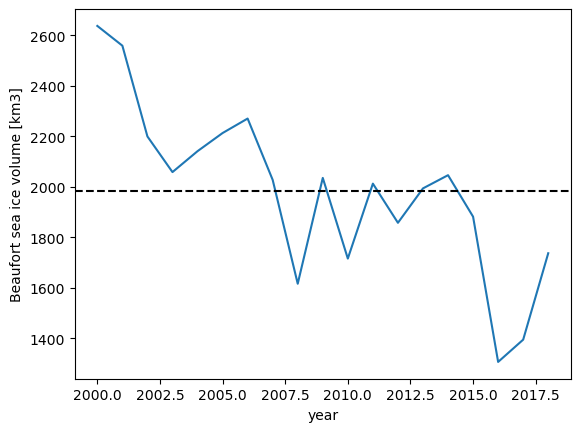

In [21]:
sivBS_june1.plot() 
plt.axhline(y=sivBS_june1_clim, color='k', ls='--')
print(sivBS_june1_clim.values)

## Plot Figure 10

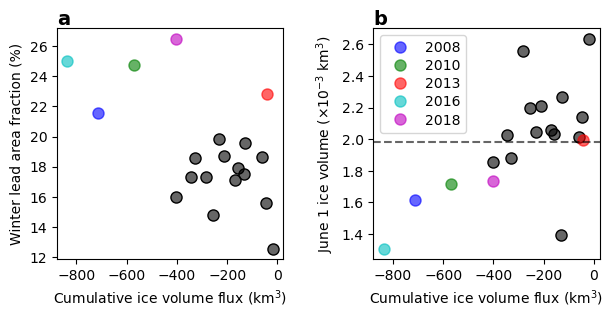

In [16]:
# Highlight breakup years
from cycler import cycler

# colors for breakup years (2008,2010,2013,2016,2018)
colors = ['b', 'g', 'r', 'c', 'm']
#markers = ['o', 'v', 's', '*', 'd']
markers = ['o', 'o', 'o', 'o', 'o']

a = np.arange(2000,2019)
b = [2008, 2010, 2013, 2016, 2018]

x = volFlx_cool  #*1E-2
y = lfa_JFM*100

y1 = sivBS_june1*1E-3 # 10⁻3 km3
x1 = volFlx_cool   #*1E-2

fig, (ax0, ax1) = plt.subplots(1,2, figsize=(7,3))
fig.subplots_adjust(hspace=0.1, wspace=0.4)

ax0.set_xlabel(r'Cumulative ice volume flux (km$^3$)')
ax0.set_ylabel('Winter lead area fraction (%)')
ax1.set_ylabel(r'June 1 ice volume ($\times10^{-3}$ km$^3$)')
ax1.set_xlabel(r'Cumulative ice volume flux (km$^3$)')

# Sp1 - lead fraction vs volume flux
ax0.plot(x.where(~np.isin(a,b)), y.where(~np.isin(a,b)), markerfacecolor=(0,0,0,.6), markeredgecolor=(0,0,0,1), linestyle='None', marker='o', markersize=8)

for i, j, color, marker in zip(x.where(np.isin(a,b)).dropna('time'),
                               y.where(np.isin(a,b)).dropna('year'), 
                               colors, 
                               markers):
    ax0.plot(i, j, linestyle='None', marker=marker ,color=color, markeredgecolor=color, alpha=0.6, markersize=8)

# Sp2 - volume flux vs june ice volume
ax1.plot(x1.where(~np.isin(a,b)), y1.where(~np.isin(a,b)), markerfacecolor=(0,0,0,.6), markeredgecolor=(0,0,0,1), linestyle='None', marker='o', markersize=8)
lines=[]
for i, j, color, marker in zip(x1.where(np.isin(a,b)).dropna('time'),
                               y1.where(np.isin(a,b)).dropna('year'), 
                               colors, 
                               markers):
    year = i.time.values
    lines += ax1.plot(i, j, linestyle='None', marker=marker ,color=color, markeredgecolor=color, alpha=0.6, markersize=8, label=str(year))

# add SIV June 1 climatology
plt.axhline(y=sivBS_june1_clim*1E-3, color='k', ls='--', alpha=0.6)

labels = [l.get_label() for l in lines]
plt.legend(lines, labels, loc='upper left', labelspacing=0.3)

# add figure labels
axes = (ax0,ax1)
labels = ['a', 'b']
for ax, lab in zip(axes, labels):
    ax.text(0.0, 1.08, lab, transform=ax.transAxes,fontsize=14, fontweight='bold', va='top')

plt.show()    
    
fig.savefig('../figures/' + f'fig10_correl_icevolFlux_leadFrac_iceVol_moore22_w-brkup.png', dpi=300, bbox_inches='tight')


## Ice fluxes versus lead area fraction

In [ ]:

fig, ax = plt.subplots(1,1, figsize=(4,4))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)

x = cool.groupby('time.year').mean('time')

y1 = lfa_JFM.sel(year=slice(2000,2007))
x1 = x.sel(year=slice(2000,2007))

y2 = lfa_JFM.sel(year=slice(2008,2018))
x2 = x.sel(year=slice(2008,2018))

h1=ax.scatter(x1*1E-2, y1, c='C0', label='2000-2007')
h2=ax.scatter(x2*1E-2, y2, c='C1', label='2008-2018')

#ax.set_title(month_names[i])
ax.set_xlabel('Cumulative Jan 1 - June 1 Ice Volume Flux ($10^2$ km$^3$)')
ax.set_ylabel('Lead area fraction')
plt.legend()

#fig.savefig(figdir + f'correl_icevolFlux_leadFrac_cool-season_moore22.png', dpi=300, bbox_inches='tight')


Here, there is clearly a grouping with winters which has high lead fractions showing greater export out of the Beaufort region. All these events are occurring after 2007. 
Would be interesting to do a similar plot with wind velocities, i.e. are there high wind events in the early period (2000-2007), but without triggering breakup? This could point to the fact that the ice cover has become more vulnerable to winds due to changes in the ice properties such as ice thinning and loss of ice strength.  

## Plot as anomalies

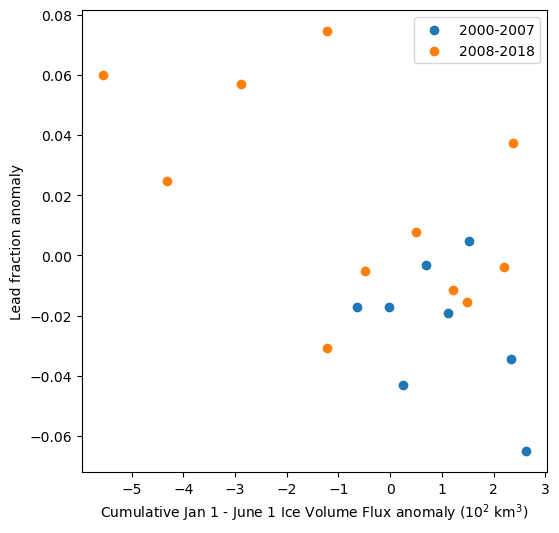

In [80]:
# Anomalies 
fig, ax = plt.subplots(1,1, figsize=(6,6))
#fig.subplots_adjust(hspace=0.4, wspace=0.4)

x = cool_anom.groupby('time.year').mean('time')
y = lfa_JFM_anom

y1 = y.sel(year=slice(2000,2007))
x1 = x.sel(year=slice(2000,2007))

y2 = y.sel(year=slice(2008,2018))
x2 = x.sel(year=slice(2008,2018))

ax.scatter(x1*1E-2, y1, c='C0', label='2000-2007')
ax.scatter(x2*1E-2, y2, c='C1', label='2008-2018')

#ax.set_title(month_names[i])
ax.set_xlabel('Cumulative Jan 1 - June 1 Ice Volume Flux anomaly ($10^2$ km$^3$)')
ax.set_ylabel('Lead fraction anomaly')
plt.legend()

#fig.savefig(figdir + f'correl_icevolFlux_leadFrac_cool-season_anom_moore22.png', dpi=300, bbox_inches='tight')
